ADMM Consensus Example
======================

A simple example demonstrating how to construct a solver for an ADMM Consensus problem by specialising [admm.ADMMConsensus](http://sporco.rtfd.org/en/latest/sporco.admm.admm.html#sporco.admm.admm.ADMMConsensus).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco.admm import admm
import sporco.linalg as spl
from sporco import plot
plot.config_notebook_plotting()

Define class solving a simple synthetic problem demonstrating the construction of an ADMM Consensus solver derived from [admm.ADMMConsensus](http://sporco.rtfd.org/en/latest/sporco.admm.admm.html#sporco.admm.admm.ADMMConsensus).

In [2]:
class ConsensusTest(admm.ADMMConsensus):
    r"""
    Solve the problem

    .. math::
       \mathrm{argmin}_\mathbf{x} \;
       (1/2) \sum_k \| A_k \mathbf{x} - \mathbf{s}_k \|_2^2 + \lambda
       \| \mathbf{x} \|_1

   via an ADMM consensus problem

   .. math::
       \mathrm{argmin}_{\mathbf{x}_k, \mathbf{y}} \;
       (1/2) \sum_k \| A_k \mathbf{x}_k - \mathbf{s}_k \|_2^2 + \lambda
       \| \mathbf{y} \|_1 \;\; \text{s.t.} \;\;
       \mathbf{x}_k = \mathbf{y} \; \forall k
    """

    def __init__(self, A, s, lmbda, opt=None):
        """
        Initialise a ConsensusTest object with problem parameters.

        Parameters
        ----------
        A : list of ndarray
          A list of arrays representing matrices :math:`A_k`
        S : list of ndarray
          A list of arrays representing vectors :math:`\mathbf{s}_k`
        opt : :class:`.ADMMConsensus.Options` object
          Algorithm options
        """

        # Default solver options if none provided
        if opt is None:
            opt = admm.ADMMConsensus.Options()

        # Set object attributes corresponding to initialiser parameters
        self.A = A
        self.s = s
        self.lmbda = lmbda
        self.rho = opt['rho']
        # The number of separate components of the consensus problem
        Nb = len(A)
        # Construct a tuple representing the shape of the auxiliary
        # variable Y in the consensus problem
        shpY = (A[0].shape[1], s[0].shape[1] if s[0].ndim > 1 else 1)
        # Call parent class initialiser
        super(ConsensusTest, self).__init__(Nb, shpY, s[0].dtype, opt)

        # Construct list of products A_k^T s_k
        self.ATS = [A[i].T.dot(s[i]) for i in range(Nb)]
        # Compute an LU factorisation for each A_k
        self.rhochange()

        # Initialise working variables
        self.X = np.zeros(shpY + (Nb,))
        self.Y = np.zeros(shpY)
        self.U = np.zeros(shpY + (Nb,))



    def rhochange(self):
        r"""
        This method is called when the penalty parameter :math:`\rho` is
        updated by the parent class solve method. It computes an LU
        factorisation of :math:`A_k^T A_k + \rho I`.
        """

        self.lu = []
        self.piv = []
        for i in range(self.Nb):
            lu, piv = spl.lu_factor(self.A[i], self.rho)
            self.lu.append(lu)
            self.piv.append(piv)



    def obfn_fi(self, Xi, i):
        r"""
        Compute :math:`(1/2) \sum_k \| A_k \mathbf{x}_k - \mathbf{s}_k
        \|_2^2`.
        """

        return 0.5*np.linalg.norm(self.A[i].dot(Xi) - self.s[i])**2



    def obfn_g(self, Y):
        r"""
        Compute :math:`\lambda \| \mathbf{x} \|_1`.
        """

        return self.lmbda * np.sum(np.abs(Y))



    def xistep(self, i):
        r"""
        Minimise Augmented Lagrangian with respect to :math:`\mathbf{x}`
        component :math:`\mathbf{x}_i`.
        """

        self.X[..., i] = spl.lu_solve_ATAI(self.A[i], self.rho,
                    self.ATS[i] + self.rho*(self.Y - self.U[..., i]),
                    self.lu[i], self.piv[i])



    def prox_g(self, X, rho):
        r"""
        Proximal operator of :math:`(\lambda/\rho) \|\cdot\|_1`.
        """

        return spl.shrink1(X, (self.lmbda/rho))

Construct random sparse vector :math:`\mathbf{x}`, random :math:`A_k` matrices, and vectors :math:`\mathbf{s}_k` such that :math:`A_k \mathbf{x} = \mathbf{s}_k`.

In [3]:
np.random.seed(12345)
x = np.random.randn(64,1)
x[np.abs(x) < 1.25] = 0
A = [np.random.randn(8, 64) for i in range(8)]
s = [A[i].dot(x) for i in range(8)]

Initialise and run `ConsensusTest` solver.

In [4]:
lmbda = 1e-1
opt = ConsensusTest.Options({'Verbose': True, 'MaxMainIter': 250,
                            'AutoRho': {'Enabled': False},
                            'rho': 2e-1, 'RelaxParam': 1.2,
                            'fEvalX': False})
b = ConsensusTest(A, s, lmbda, opt)
yr = b.solve()
print("ConsensusTest solve time: %.2fs" % b.timer.elapsed('solve'))

Itn   Fnc       f         g         r         s         
------------------------------------------------------
   0  1.02e+03  1.02e+03  4.98e-01  8.93e-01  3.74e-01
   1  3.81e+02  3.79e+02  1.55e+00  5.04e-01  4.44e-01
   2  1.56e+02  1.53e+02  2.70e+00  1.86e-01  4.24e-01
   3  2.25e+02  2.22e+02  3.54e+00  1.54e-01  3.58e-01
   4  2.94e+02  2.90e+02  4.02e+00  1.54e-01  2.83e-01
   5  2.58e+02  2.54e+02  4.15e+00  1.42e-01  2.42e-01
   6  1.71e+02  1.67e+02  4.09e+00  1.21e-01  2.34e-01
   7  1.06e+02  1.02e+02  3.91e+00  9.69e-02  2.43e-01
   8  8.91e+01  8.54e+01  3.72e+00  8.67e-02  2.27e-01
   9  8.71e+01  8.36e+01  3.58e+00  8.72e-02  1.97e-01
  10  7.12e+01  6.77e+01  3.51e+00  8.12e-02  1.72e-01
  11  5.60e+01  5.25e+01  3.49e+00  6.85e-02  1.55e-01
  12  4.67e+01  4.32e+01  3.52e+00  6.25e-02  1.38e-01
  13  3.67e+01  3.32e+01  3.51e+00  5.29e-02  1.36e-01
  14  2.65e+01  2.30e+01  3.47e+00  4.55e-02  1.38e-01
  15  1.90e+01  1.56e+01  3.43e+00  4.19e-02  1.22e-01
  16  1.

 115  2.92e+00  6.41e-03  2.92e+00  1.07e-03  1.55e-03
 116  2.92e+00  6.00e-03  2.92e+00  1.07e-03  1.22e-03
 117  2.92e+00  5.03e-03  2.92e+00  1.05e-03  1.25e-03
 118  2.92e+00  3.75e-03  2.92e+00  1.02e-03  1.55e-03
 119  2.92e+00  2.47e-03  2.92e+00  9.76e-04  1.91e-03
 120  2.92e+00  1.54e-03  2.92e+00  9.33e-04  2.19e-03
 121  2.92e+00  1.16e-03  2.92e+00  9.01e-04  2.36e-03
 122  2.92e+00  1.40e-03  2.92e+00  8.82e-04  2.40e-03
 123  2.92e+00  2.17e-03  2.92e+00  8.78e-04  2.34e-03
 124  2.92e+00  3.25e-03  2.92e+00  8.82e-04  2.19e-03
 125  2.92e+00  4.40e-03  2.92e+00  8.88e-04  2.02e-03
 126  2.92e+00  5.43e-03  2.91e+00  8.90e-04  1.88e-03
 127  2.92e+00  6.22e-03  2.91e+00  8.87e-04  1.79e-03
 128  2.92e+00  6.77e-03  2.91e+00  8.78e-04  1.77e-03
 129  2.92e+00  7.15e-03  2.91e+00  8.68e-04  1.77e-03
 130  2.92e+00  7.43e-03  2.91e+00  8.59e-04  1.75e-03
 131  2.92e+00  7.67e-03  2.91e+00  8.56e-04  1.68e-03
 132  2.92e+00  7.89e-03  2.91e+00  8.58e-04  1.54e-03
 133  2.92

Plot reference and reconstructed sparse representations.

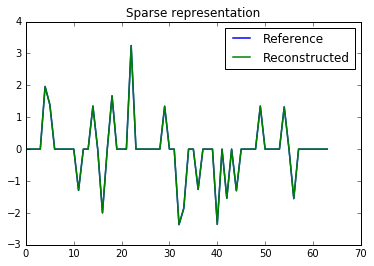

In [5]:
plot.plot(np.hstack((x, yr)), fgnm=1, title='Sparse representation',
        lgnd=['Reference', 'Reconstructed'])

Plot functional value, residuals, and rho.

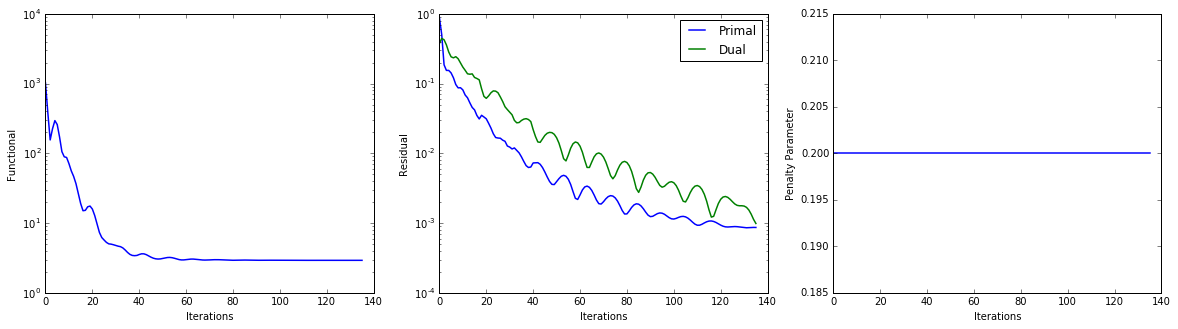

In [6]:
its = b.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(its.ObjFun, fgrf=fig, ptyp='semilogy', xlbl='Iterations',
        ylbl='Functional')
plot.subplot(1, 3, 2)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, fgrf=fig,
        ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
        lgnd=['Primal', 'Dual']);
plot.subplot(1, 3, 3)
plot.plot(its.Rho, fgrf=fig, xlbl='Iterations', ylbl='Penalty Parameter')
fig.show()